In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/readme.txt
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s4.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/12_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/18_MR_s2.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/3_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/16_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/9_MR_s5.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/17_MR_s3.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/15_MR_s1.dcm
/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR/

In [2]:
# %% 1) Install dependencies (if not present)
try:
    import pytorch_fid
    import lpips
    import pydicom
    import torchmetrics
    import cv2
except Exception:
    !pip install --quiet pytorch-fid lpips pydicom torchmetrics opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Imports
# ─────────────────────────────────────────────────────────────────────────────
import os, glob, csv, json, time, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import pydicom
from tqdm import tqdm
import pandas as pd

import cv2
from tqdm import tqdm
from pytorch_fid import fid_score
from lpips import LPIPS
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [4]:
# Kaggle paths
MR_FOLDER = "/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR"
CT_FOLDER = "/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT"

# Output directory
OUT_DIR = "outputs_hybrid"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "plots"), exist_ok=True)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# %% 2) DICOM → PIL (grayscale, windowed)
# ─────────────────────────────────────────────────────────────────────────────
def dcm_to_pil(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32)
    # Simple HU window: brain [-100, 300] → [0, 1]
    img = np.clip(img, -100, 300)
    img = (img + 100) / 400.0
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img).convert('L')

In [6]:
# %% 3) Transforms & Dataset
# ─────────────────────────────────────────────────────────────────────────────
IMAGE_SIZE = 256

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),                     # (1, H, W) in [0,1]
    T.Normalize([0.5], [0.5])         # → [-1, 1]
])

class MRCTDataset(Dataset):
    def __len__(self):
        return min(len(glob.glob(os.path.join(MR_FOLDER, "*.dcm"))),
                   len(glob.glob(os.path.join(CT_FOLDER, "*.dcm"))))
    
    def __getitem__(self, idx):
        mr_path = sorted(glob.glob(os.path.join(MR_FOLDER, "*.dcm")))[idx]
        ct_path = sorted(glob.glob(os.path.join(CT_FOLDER, "*.dcm")))[idx]
        mr = dcm_to_pil(mr_path)
        ct = dcm_to_pil(ct_path)
        return transform(mr), transform(ct)

dataset = MRCTDataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
print(f"Dataset size: {len(dataset)} pairs")

Dataset size: 88 pairs


In [7]:
# %% 4) Model: HybridCycleCUT (CycleGAN + CUT with shared MLP)
# ─────────────────────────────────────────────────────────────────────────────
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_res=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        ]
        for _ in range(n_res):
            model += [ResBlock(256)]
        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_ch, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        model = [
            nn.Conv2d(in_ch, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class MLP(nn.Module):
    def __init__(self, in_dim=256, out_dim=256, hidden=256):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.layer(x)

class HybridCycleCUT(nn.Module):
    def __init__(self):
        super().__init__()
        self.G_A2B = Generator(in_ch=1, out_ch=1)  # MR → CT
        self.G_B2A = Generator(in_ch=1, out_ch=1)  # CT → MR
        self.D_A = Discriminator(in_ch=1)
        self.D_B = Discriminator(in_ch=1)
        self.mlp = MLP(in_dim=256)  # shared head

    def _get_feat(self, x, gen):
        for i, layer in enumerate(gen.model[:8]):  # after second downsample
            x = layer(x)
        return x  # (B, 256, H/4, W/4)

    def forward(self, real_A, real_B):
        fake_B = self.G_A2B(real_A)
        fake_A = self.G_B2A(real_B)
        rec_A  = self.G_B2A(fake_B)
        rec_B  = self.G_A2B(fake_A)

        # Extract CUT features
        feat_real_A = self._get_feat(real_A, self.G_B2A)
        feat_fake_B = self._get_feat(fake_B, self.G_B2A)
        feat_real_B = self._get_feat(real_B, self.G_A2B)
        feat_fake_A = self._get_feat(fake_A, self.G_A2B)

        B, C, H, W = feat_real_A.shape
        N = H * W
        def _proj(f):
            f = f.view(B, C, N).permute(0, 2, 1)  # (B, N, C)
            return self.mlp(f)                    # (B, N, 256)
        
        proj_real_A = _proj(feat_real_A)
        proj_fake_B = _proj(feat_fake_B)
        proj_real_B = _proj(feat_real_B)
        proj_fake_A = _proj(feat_fake_A)

        return (fake_B, fake_A, rec_A, rec_B,
                proj_real_A, proj_fake_B, proj_real_B, proj_fake_A)

In [8]:
# %% 5) Optimizers & Losses
# ─────────────────────────────────────────────────────────────────────────────
model = HybridCycleCUT().to(DEVICE)

optim_G = optim.Adam(
    itertools.chain(model.G_A2B.parameters(),
                    model.G_B2A.parameters(),
                    model.mlp.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
optim_D = optim.Adam(
    itertools.chain(model.D_A.parameters(), model.D_B.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)

criterionGAN = nn.MSELoss()
criterionCyc = nn.L1Loss()
criterionId  = nn.L1Loss()

def calc_patchnce_loss(f_s, f_t, tau=0.07):
    f_s = F.normalize(f_s, dim=-1)
    f_t = F.normalize(f_t, dim=-1)
    sim = torch.bmm(f_s, f_t.transpose(1, 2)) / tau
    labels = torch.arange(f_s.size(1), device=f_s.device).expand(f_s.size(0), -1)
    return F.cross_entropy(sim, labels)

In [9]:
# %% 6) Hyper-parameters
# ─────────────────────────────────────────────────────────────────────────────
N_EPOCHS    = 100
SAVE_EVERY  = 10
lambda_cyc  = 10.0
lambda_id   = 5.0
lambda_cut  = 1.0

In [10]:
# %% 7) Logging: CSV Header
# ─────────────────────────────────────────────────────────────────────────────
metrics_csv = os.path.join(OUT_DIR, "training_log.csv")
if not os.path.exists(metrics_csv):
    with open(metrics_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'epoch', 'G_GAN', 'G_Cycle', 'G_Id', 'G_CUT', 'G_total',
            'D_real', 'D_fake', 'D_total', 'lr',
            'fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse'
        ])

In [11]:
# %% 8) Sanity Check: Forward Pass
# ─────────────────────────────────────────────────────────────────────────────
real_A, real_B = next(iter(dataloader))
real_A, real_B = real_A.to(DEVICE), real_B.to(DEVICE)

with torch.no_grad():
    out = model(real_A, real_B)
    for i, name in enumerate(['fake_B', 'fake_A', 'rec_A', 'rec_B',
                              'proj_real_A', 'proj_fake_B', 'proj_real_B', 'proj_fake_A']):
        print(f"{name}: {out[i].shape}")

print("\nModel, data, and logging are ready. Start training with the loop below.")

fake_B: torch.Size([1, 1, 256, 256])
fake_A: torch.Size([1, 1, 256, 256])
rec_A: torch.Size([1, 1, 256, 256])
rec_B: torch.Size([1, 1, 256, 256])
proj_real_A: torch.Size([1, 4096, 256])
proj_fake_B: torch.Size([1, 4096, 256])
proj_real_B: torch.Size([1, 4096, 256])
proj_fake_A: torch.Size([1, 4096, 256])

Model, data, and logging are ready. Start training with the loop below.


In [12]:
# Paths
OUT_DIR = "outputs_hybrid"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "plots"), exist_ok=True)

MR_FOLDER = "/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/MR/image_MR"
CT_FOLDER = "/kaggle/input/unpaired-mr-ct-brain-dataset/JUH_MR-CT_dataset/CT/image_CT"

IMAGE_SIZE = 256
SAVE_EVERY = 10
N_EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # [-1,1]
])

# Metrics CSV
metrics_csv = os.path.join(OUT_DIR, "training_log.csv")
if not os.path.exists(metrics_csv):
    with open(metrics_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'epoch', 'G_GAN', 'G_Cycle', 'G_Id', 'G_CUT', 'G_total',
            'D_real', 'D_fake', 'D_total', 'lr',
            'fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse'
        ])

In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# 2. Training loop with CSV + checkpoint
# ─────────────────────────────────────────────────────────────────────────────
model = HybridCycleCUT().to(DEVICE)
optim_G = torch.optim.Adam(
    itertools.chain(model.G_A2B.parameters(), model.G_B2A.parameters(), model.mlp.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
optim_D = torch.optim.Adam(
    itertools.chain(model.D_A.parameters(), model.D_B.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)

criterionGAN = nn.MSELoss()
criterionCyc = nn.L1Loss()
criterionId  = nn.L1Loss()

lambda_cyc = 10.0
lambda_id  = 5.0
lambda_cut = 1.0

for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    meter_G_GAN = meter_G_Cycle = meter_G_Id = meter_G_CUT = meter_G = 0.0
    meter_D_real = meter_D_fake = meter_D = 0.0
    n_batches = 0

    model.train()
    for real_A, real_B in dataloader:
        real_A, real_B = real_A.to(DEVICE), real_B.to(DEVICE)
        batch_size = real_A.size(0)

        # Forward
        (fake_B, fake_A, rec_A, rec_B,
         proj_real_A, proj_fake_B, proj_real_B, proj_fake_A) = model(real_A, real_B)

        # === Discriminator ===
        loss_D_A_real = criterionGAN(model.D_A(real_A), torch.ones_like(model.D_A(real_A)))
        loss_D_A_fake = criterionGAN(model.D_A(fake_A.detach()), torch.zeros_like(model.D_A(fake_A)))
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5

        loss_D_B_real = criterionGAN(model.D_B(real_B), torch.ones_like(model.D_B(real_B)))
        loss_D_B_fake = criterionGAN(model.D_B(fake_B.detach()), torch.zeros_like(model.D_B(fake_B)))
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5

        loss_D = loss_D_A + loss_D_B
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

        # === Generator ===
        loss_G_A = criterionGAN(model.D_A(fake_A), torch.ones_like(model.D_A(fake_A)))
        loss_G_B = criterionGAN(model.D_B(fake_B), torch.ones_like(model.D_B(fake_B)))
        loss_G_GAN = (loss_G_A + loss_G_B) * 0.5

        loss_cycle_A = criterionCyc(rec_A, real_A) * lambda_cyc
        loss_cycle_B = criterionCyc(rec_B, real_B) * lambda_cyc
        loss_cycle = loss_cycle_A + loss_cycle_B

        id_A = model.G_B2A(real_A)
        id_B = model.G_A2B(real_B)
        loss_id_A = criterionId(id_A, real_A) * lambda_id
        loss_id_B = criterionId(id_B, real_B) * lambda_id
        loss_id = loss_id_A + loss_id_B

        loss_cut_AB = calc_patchnce_loss(proj_real_A, proj_fake_B) * lambda_cut
        loss_cut_BA = calc_patchnce_loss(proj_real_B, proj_fake_A) * lambda_cut
        loss_cut = loss_cut_AB + loss_cut_BA

        loss_G = loss_G_GAN + loss_cycle + loss_id + loss_cut
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()

        # Accumulate
        meter_G_GAN   += loss_G_GAN.item()   * batch_size
        meter_G_Cycle += loss_cycle.item()   * batch_size
        meter_G_Id    += loss_id.item()      * batch_size
        meter_G_CUT   += loss_cut.item()     * batch_size
        meter_G       += loss_G.item()       * batch_size
        meter_D_real  += (loss_D_A_real + loss_D_B_real).item() * batch_size
        meter_D_fake  += (loss_D_A_fake + loss_D_B_fake).item() * batch_size
        meter_D       += loss_D.item()       * batch_size
        n_batches += batch_size

    # Average
    for k in ['G_GAN','G_Cycle','G_Id','G_CUT','G','D_real','D_fake','D']:
        globals()[f'meter_{k}'] /= n_batches

    # === Save checkpoint ===
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'hybrid_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optim_G': optim_G.state_dict(),
            'optim_D': optim_D.state_dict(),
        }, ckpt_path)

    # === Log to CSV (metrics later) ===
    with open(metrics_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch,
            f"{meter_G_GAN:.5f}", f"{meter_G_Cycle:.5f}", f"{meter_G_Id:.5f}",
            f"{meter_G_CUT:.5f}", f"{meter_G:.5f}",
            f"{meter_D_real:.5f}", f"{meter_D_fake:.5f}", f"{meter_D:.5f}",
            f"{optim_G.param_groups[0]['lr']:.6f}",
            '', '', '', '', '', ''  # placeholders
        ])

    t1 = time.time()
    print(f"Epoch {epoch:3d} | G:{meter_G:.4f} | D:{meter_D:.4f} | "
          f"GAN:{meter_G_GAN:.4f} | Cyc:{meter_G_Cycle:.4f} | Id:{meter_G_Id:.4f} | CUT:{meter_G_CUT:.4f} | "
          f"Time:{t1-t0:.1f}s")

Epoch   1 | G:13.7314 | D:0.5769 | GAN:0.5341 | Cyc:2.1183 | Id:0.9684 | CUT:10.1107 | Time:56.9s
Epoch   2 | G:10.3308 | D:0.3444 | GAN:0.6092 | Cyc:1.3447 | Id:0.6091 | CUT:7.7678 | Time:59.8s
Epoch   3 | G:9.3912 | D:0.3193 | GAN:0.6477 | Cyc:1.1549 | Id:0.5348 | CUT:7.0538 | Time:59.3s
Epoch   4 | G:8.7454 | D:0.2951 | GAN:0.6742 | Cyc:1.0603 | Id:0.4888 | CUT:6.5222 | Time:59.2s
Epoch   5 | G:8.3183 | D:0.2700 | GAN:0.7039 | Cyc:0.9634 | Id:0.4416 | CUT:6.2094 | Time:59.2s
Epoch   6 | G:8.1713 | D:0.2929 | GAN:0.7011 | Cyc:0.9600 | Id:0.4466 | CUT:6.0636 | Time:59.3s
Epoch   7 | G:7.9612 | D:0.2492 | GAN:0.7022 | Cyc:0.9081 | Id:0.4287 | CUT:5.9223 | Time:59.4s
Epoch   8 | G:7.7725 | D:0.2786 | GAN:0.6963 | Cyc:0.8553 | Id:0.4038 | CUT:5.8170 | Time:59.4s
Epoch   9 | G:7.7238 | D:0.2620 | GAN:0.7183 | Cyc:0.8449 | Id:0.3976 | CUT:5.7631 | Time:59.3s
Epoch  10 | G:7.6372 | D:0.2932 | GAN:0.6999 | Cyc:0.8244 | Id:0.3904 | CUT:5.7226 | Time:59.7s
Epoch  11 | G:7.5316 | D:0.2491 | GAN

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# 3. Inference helper (no encoder, just G_A2B)
# ─────────────────────────────────────────────────────────────────────────────
def generate_folder_from_dcm(netG, source_dcm_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    dcm_paths = sorted(glob.glob(os.path.join(source_dcm_folder, "*.dcm")))
    for p in tqdm(dcm_paths, desc=f"Generating → {out_folder}"):
        img = dcm_to_pil(p).resize((IMAGE_SIZE, IMAGE_SIZE))
        x = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            y = netG(x)
        y = (y + 1) / 2
        save_image(y, os.path.join(out_folder, os.path.basename(p).replace('.dcm', '.png')))

generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
generate_folder_from_dcm(model.G_A2B, MR_FOLDER, generated_A2B_folder)

Generating → outputs_hybrid/generated_A2B: 100%|██████████| 90/90 [00:04<00:00, 22.31it/s]


In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# 4. Full metrics (same as your Augmented version)
# ─────────────────────────────────────────────────────────────────────────────
def calculate_metrics_A2B(generated_folder, real_dcm_folder, tmp_real_folder, n_eval=200):
    os.makedirs(tmp_real_folder, exist_ok=True)
    real_paths_dcm = sorted(glob.glob(os.path.join(real_dcm_folder, "*.dcm")))
    for i, p in enumerate(tqdm(real_paths_dcm, desc="Converting real CT")):
        im = dcm_to_pil(p).resize((IMAGE_SIZE, IMAGE_SIZE))
        im.save(os.path.join(tmp_real_folder, f"ct_{i:05d}.png"))

    fake_paths = sorted(glob.glob(os.path.join(generated_folder, "*.png")))
    real_paths = sorted(glob.glob(os.path.join(tmp_real_folder, "*.png")))

    metrics = {'fid': 'N/A', 'lpips': 'N/A', 'psnr': 'N/A', 'ssim': 'N/A', 'rmse': 'N/A', 'mse': 'N/A'}
    lpips_fn = LPIPS(net='vgg').to(DEVICE)

    # FID
    try:
        fid_val = fid_score.calculate_fid_given_paths([tmp_real_folder, generated_folder], batch_size=16, device=DEVICE, dims=2048)
        metrics['fid'] = fid_val
        print(f"FID: {fid_val:.4f}")
    except Exception as e:
        print(f"FID failed: {e}")

    # IQA
    n_eval = min(len(fake_paths), len(real_paths), n_eval)
    if n_eval > 0:
        s_lpips = s_psnr = s_ssim = s_rmse = s_mse = 0.0
        for i in tqdm(range(n_eval), desc="IQA"):
            f_img = Image.open(fake_paths[i]).convert('L')
            r_img = Image.open(real_paths[i % len(real_paths)]).convert('L')
            f_tensor = T.ToTensor()(f_img).unsqueeze(0).to(DEVICE) * 2 - 1
            r_tensor = T.ToTensor()(r_img).unsqueeze(0).to(DEVICE) * 2 - 1

            # LPIPS
            s_lpips += lpips_fn(f_tensor, r_tensor).item()

            # PSNR/SSIM
            f_np = (f_tensor.squeeze().cpu().numpy() * 0.5 + 0.5)
            r_np = (r_tensor.squeeze().cpu().numpy() * 0.5 + 0.5)
            s_psnr += psnr(r_np, f_np, data_range=1.0)
            s_ssim += ssim(r_np, f_np, data_range=1.0)

            # MSE/RMSE
            mse_val = np.mean((f_np - r_np)**2)
            s_mse += mse_val
            s_rmse += np.sqrt(mse_val)

        metrics.update({
            'lpips': s_lpips / n_eval,
            'psnr': s_psnr / n_eval,
            'ssim': s_ssim / n_eval,
            'rmse': s_rmse / n_eval,
            'mse': s_mse / n_eval
        })

    # Save final metrics
    final_csv = os.path.join(OUT_DIR, 'final_metrics.csv')
    with open(final_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(metrics.keys())
        writer.writerow(metrics.values())

    # Update training log
    import pandas as pd
    df = pd.read_csv(metrics_csv)
    last_epoch = df['epoch'].iloc[-1]
    df.loc[df['epoch'] == last_epoch, list(metrics.keys())] = list(metrics.values())
    df.to_csv(metrics_csv, index=False)

    return metrics

tmp_real_ct = os.path.join(OUT_DIR, 'tmp_real_CT')
final_metrics = calculate_metrics_A2B(generated_A2B_folder, CT_FOLDER, tmp_real_ct, n_eval=200)

Converting real CT: 100%|██████████| 88/88 [00:00<00:00, 163.75it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 6/6 [00:00<00:00, 10.93it/s]


FID: 162.2863


IQA: 100%|██████████| 88/88 [00:02<00:00, 37.55it/s]


In [17]:
import pandas as pd

df = pd.read_csv(metrics_csv)
last_epoch = df['epoch'].iloc[-1]

# ✅ Use final_metrics instead of metrics
df.loc[df['epoch'] == last_epoch, list(final_metrics.keys())] = list(final_metrics.values())
df.to_csv(metrics_csv, index=False)

# ✅ Display results
display(pd.DataFrame([final_metrics]))

fid     lpips       psnr      ssim     rmse       mse
0  162.286297  0.506941  13.999132  0.583925  0.20134  0.041248

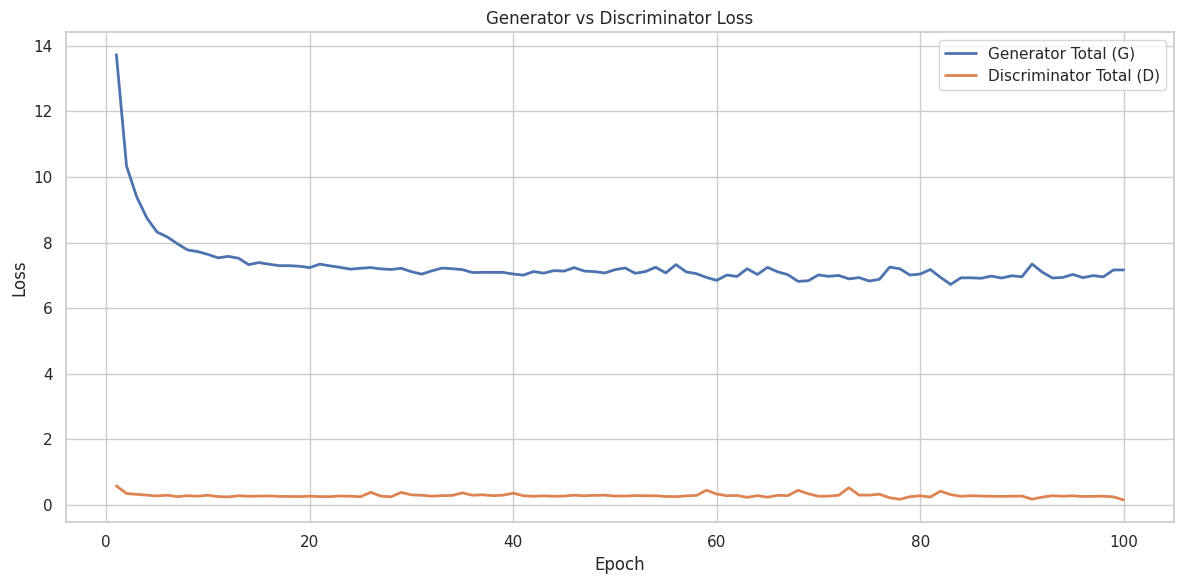

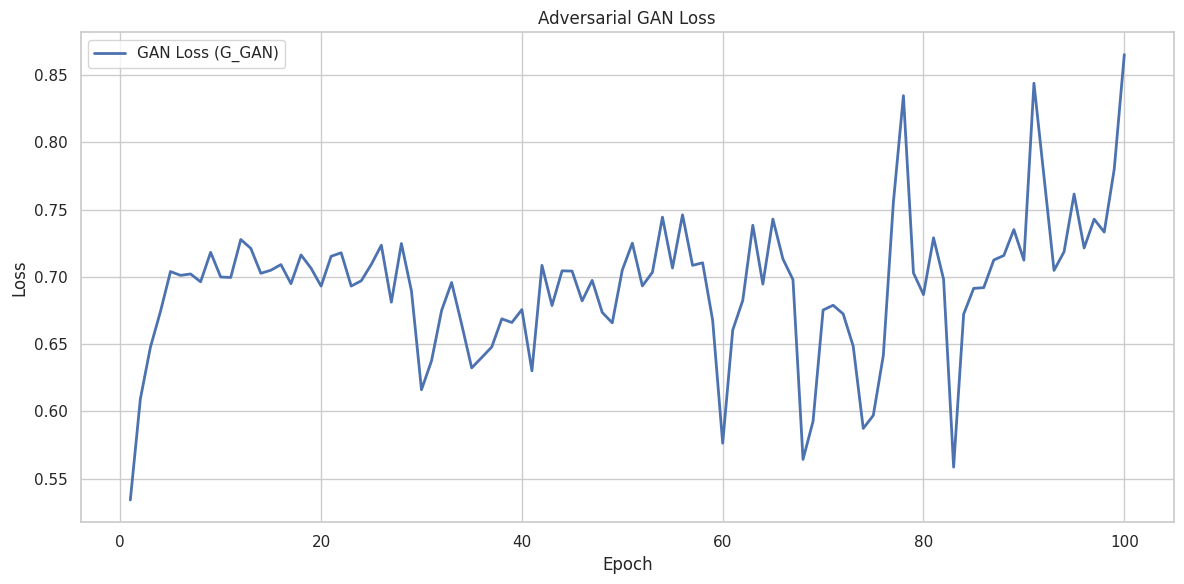

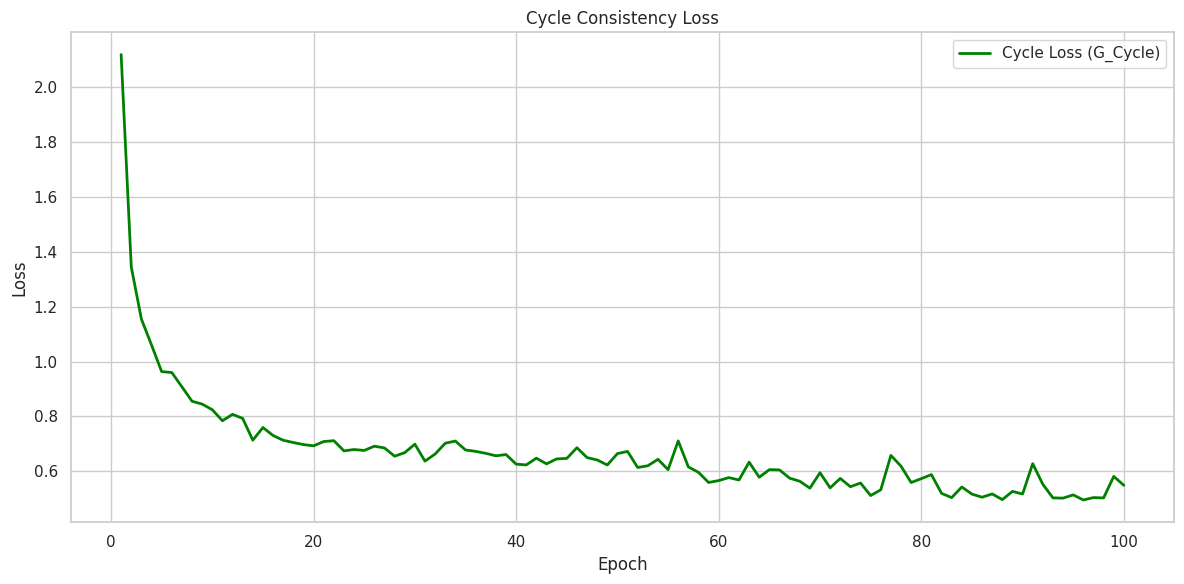

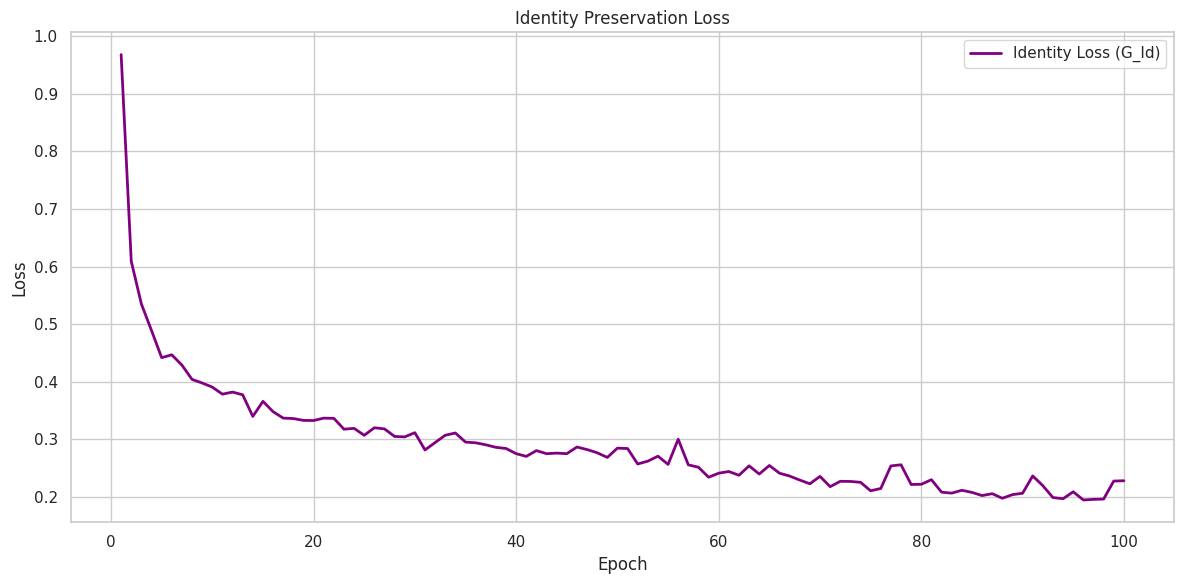

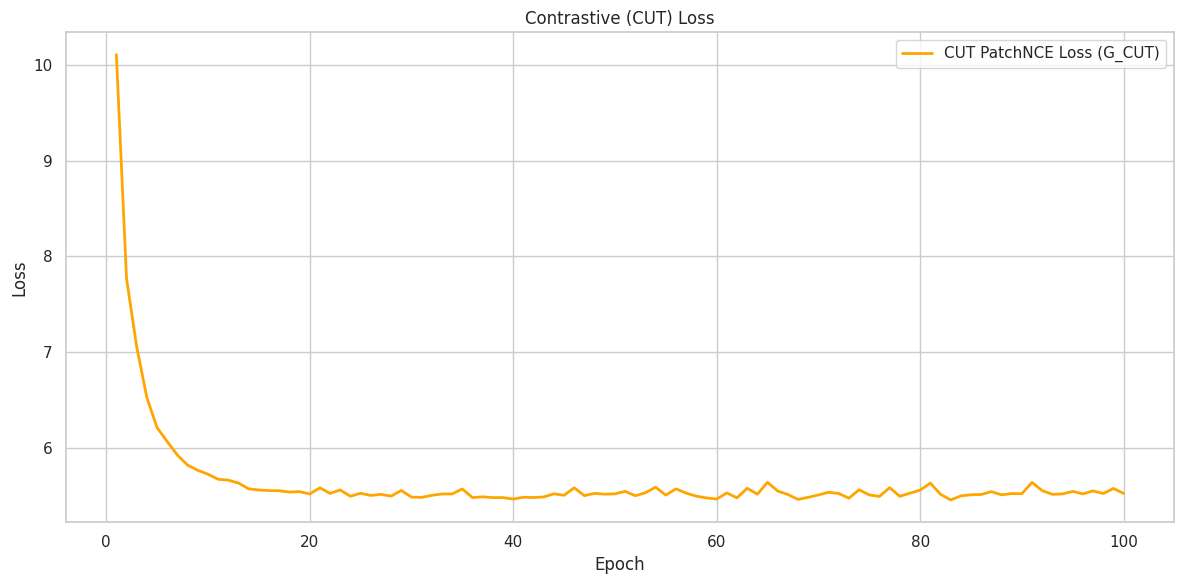

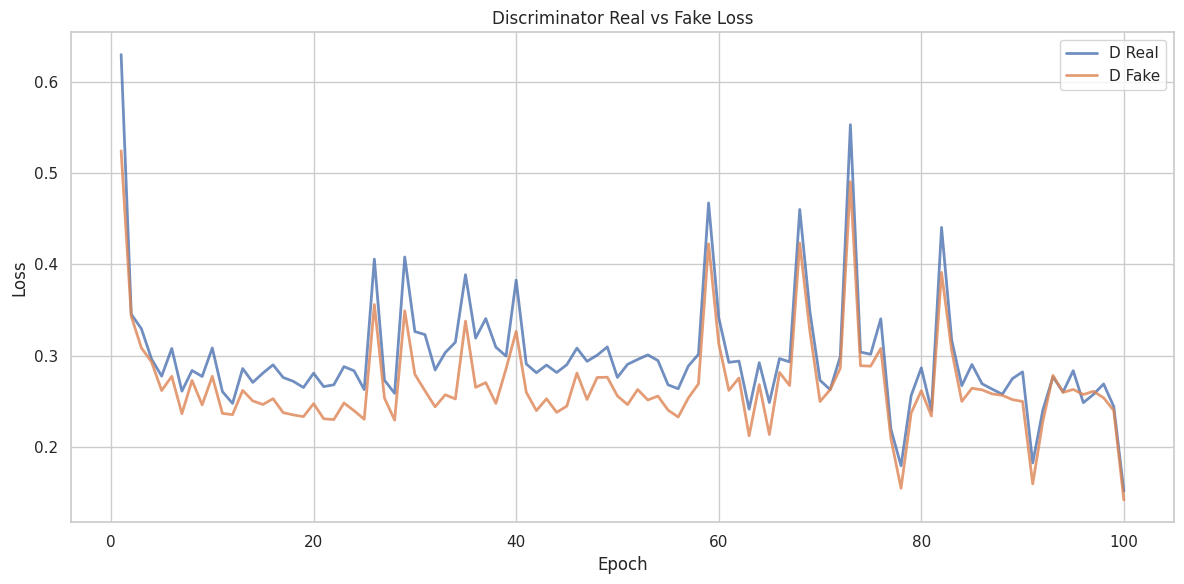

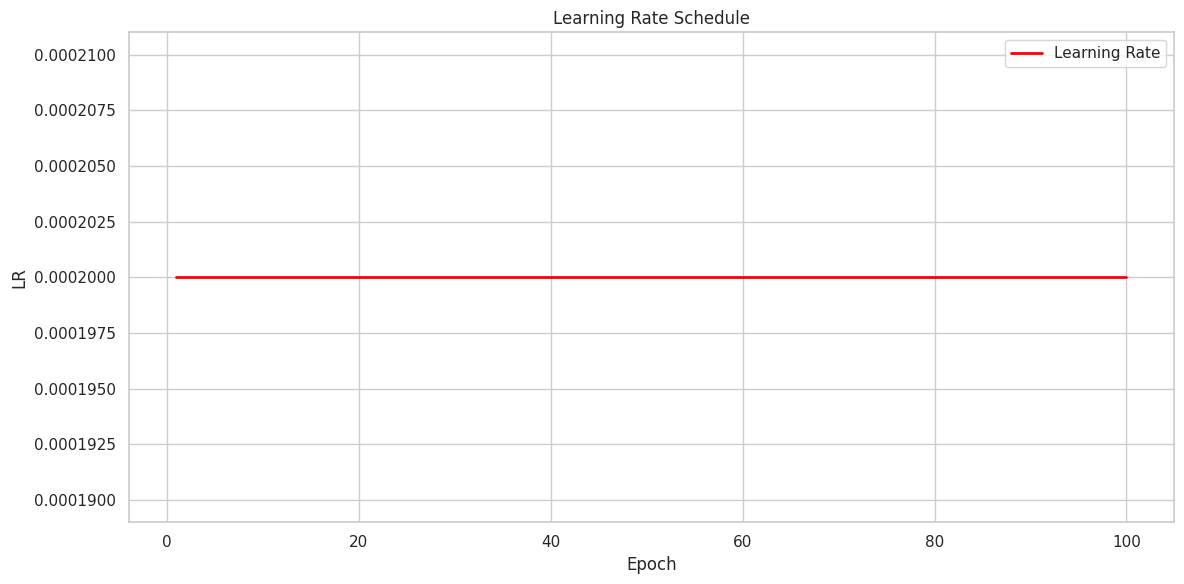

In [23]:
# ─────────────────────────────────────────────────────────────────────────────
# 10) Load CSV & Plot Training Curves (HybridCycleCUT style)
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

metrics_csv = os.path.join(OUT_DIR, "training_log.csv")
df = pd.read_csv(metrics_csv)

# Ensure columns exist (in case early epochs missing metrics)
required_cols = ['epoch', 'G_GAN', 'G_Cycle', 'G_Id', 'G_CUT', 'G_total',
                 'D_real', 'D_fake', 'D_total', 'lr']
for col in required_cols:
    if col not in df.columns:
        df[col] = 0.0

# ───── 1. Generator & Discriminator Total ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['G_total'], label='Generator Total (G)', linewidth=2)
plt.plot(df['epoch'], df['D_total'], label='Discriminator Total (D)', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator vs Discriminator Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_G_vs_D.png'), dpi=200)
plt.show()

# ───── 2. GAN Losses (A2B & B2A) ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['G_GAN'], label='GAN Loss (G_GAN)', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Adversarial GAN Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_GAN.png'), dpi=200)
plt.show()

# ───── 3. Cycle Consistency Losses ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['G_Cycle'], label='Cycle Loss (G_Cycle)', color='green', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cycle Consistency Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_Cycle.png'), dpi=200)
plt.show()

# ───── 4. Identity Losses ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['G_Id'], label='Identity Loss (G_Id)', color='purple', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Identity Preservation Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_Identity.png'), dpi=200)
plt.show()

# ───── 5. CUT (PatchNCE) Loss ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['G_CUT'], label='CUT PatchNCE Loss (G_CUT)', color='orange', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Contrastive (CUT) Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_CUT.png'), dpi=200)
plt.show()

# ───── 6. Discriminator Components ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['D_real'], label='D Real', linewidth=2, alpha=0.8)
plt.plot(df['epoch'], df['D_fake'], label='D Fake', linewidth=2, alpha=0.8)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Discriminator Real vs Fake Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'loss_D_real_fake.png'), dpi=200)
plt.show()

# ───── 7. Learning Rate ─────
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['lr'], label='Learning Rate', color='red', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('LR'); plt.title('Learning Rate Schedule')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'plots', 'learning_rate.png'), dpi=200)
plt.show()

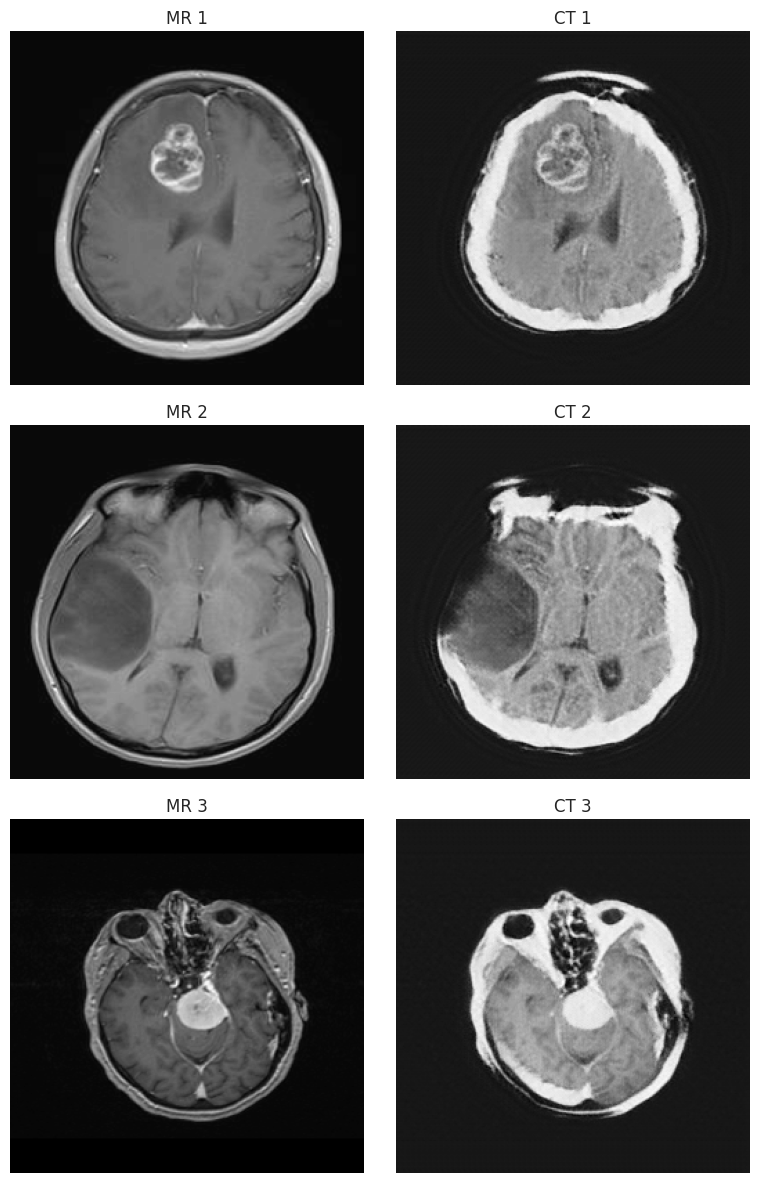

In [19]:
# ─────────────────────────────────────────────────────────────────────────────
# 6. Sample translation pairs
# ─────────────────────────────────────────────────────────────────────────────
gen_folder = generated_A2B_folder
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, "*.dcm")))
n_show = 3
idxs = [0, len(mr_paths)//2, len(mr_paths)-1][:n_show]
selected = [mr_paths[i] for i in idxs]

fig, axs = plt.subplots(n_show, 2, figsize=(8, 4*n_show))
for i, mr_p in enumerate(selected):
    mr_img = dcm_to_pil(mr_p).resize((IMAGE_SIZE, IMAGE_SIZE))
    base = os.path.basename(mr_p).replace('.dcm', '.png')
    gen_p = os.path.join(gen_folder, base)
    gen_img = Image.open(gen_p).convert('L').resize((IMAGE_SIZE, IMAGE_SIZE))
    axs[i,0].imshow(mr_img, cmap='gray'); axs[i,0].set_title(f"MR {i+1}"); axs[i,0].axis('off')
    axs[i,1].imshow(gen_img, cmap='gray'); axs[i,1].set_title(f"CT {i+1}"); axs[i,1].axis('off')
plt.tight_layout()
save_path = os.path.join(OUT_DIR, 'plots', 'sample_pairs.png')
plt.savefig(save_path, dpi=150)
plt.show()

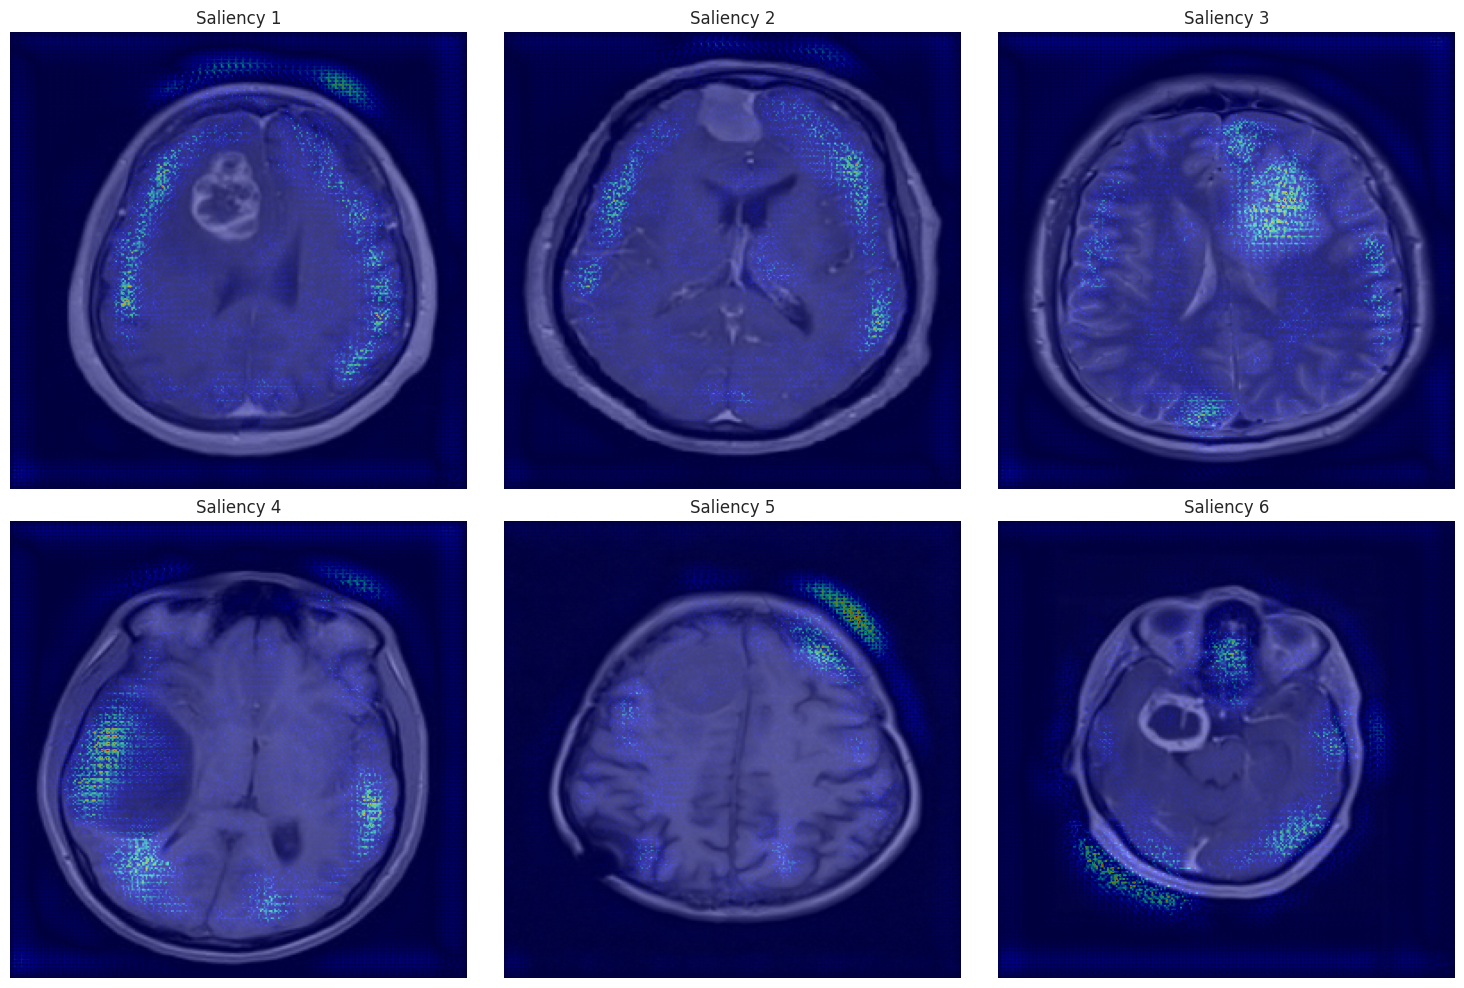

In [20]:
# ─────────────────────────────────────────────────────────────────────────────
# 7. Saliency Visualization
# ─────────────────────────────────────────────────────────────────────────────
def compute_saliency(netG, x):
    x.requires_grad_(True)
    fake = netG(x)
    score = fake.mean()
    netG.zero_grad()
    score.backward()
    sal = x.grad.abs().sum(1).squeeze().cpu().numpy()
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

xai_folder = os.path.join(OUT_DIR, 'xai')
os.makedirs(xai_folder, exist_ok=True)
mr_paths = sorted(glob.glob(os.path.join(MR_FOLDER, "*.dcm")))

n_show = min(6, len(mr_paths))
step = max(1, len(mr_paths)//n_show)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (ax, p) in enumerate(zip(axes, mr_paths[::step][:n_show])):
    img = dcm_to_pil(p)
    x = transform(img).unsqueeze(0).to(DEVICE)
    sal = compute_saliency(model.G_A2B, x)

    # Convert to numpy for display
    img_np = (x[0].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).squeeze()

    ax.imshow(img_np, cmap='gray')
    ax.imshow(sal, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Saliency {i+1}")

    # Save each image
    plt.imsave(os.path.join(xai_folder, f"saliency_{i:03d}.png"), sal, cmap='jet')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


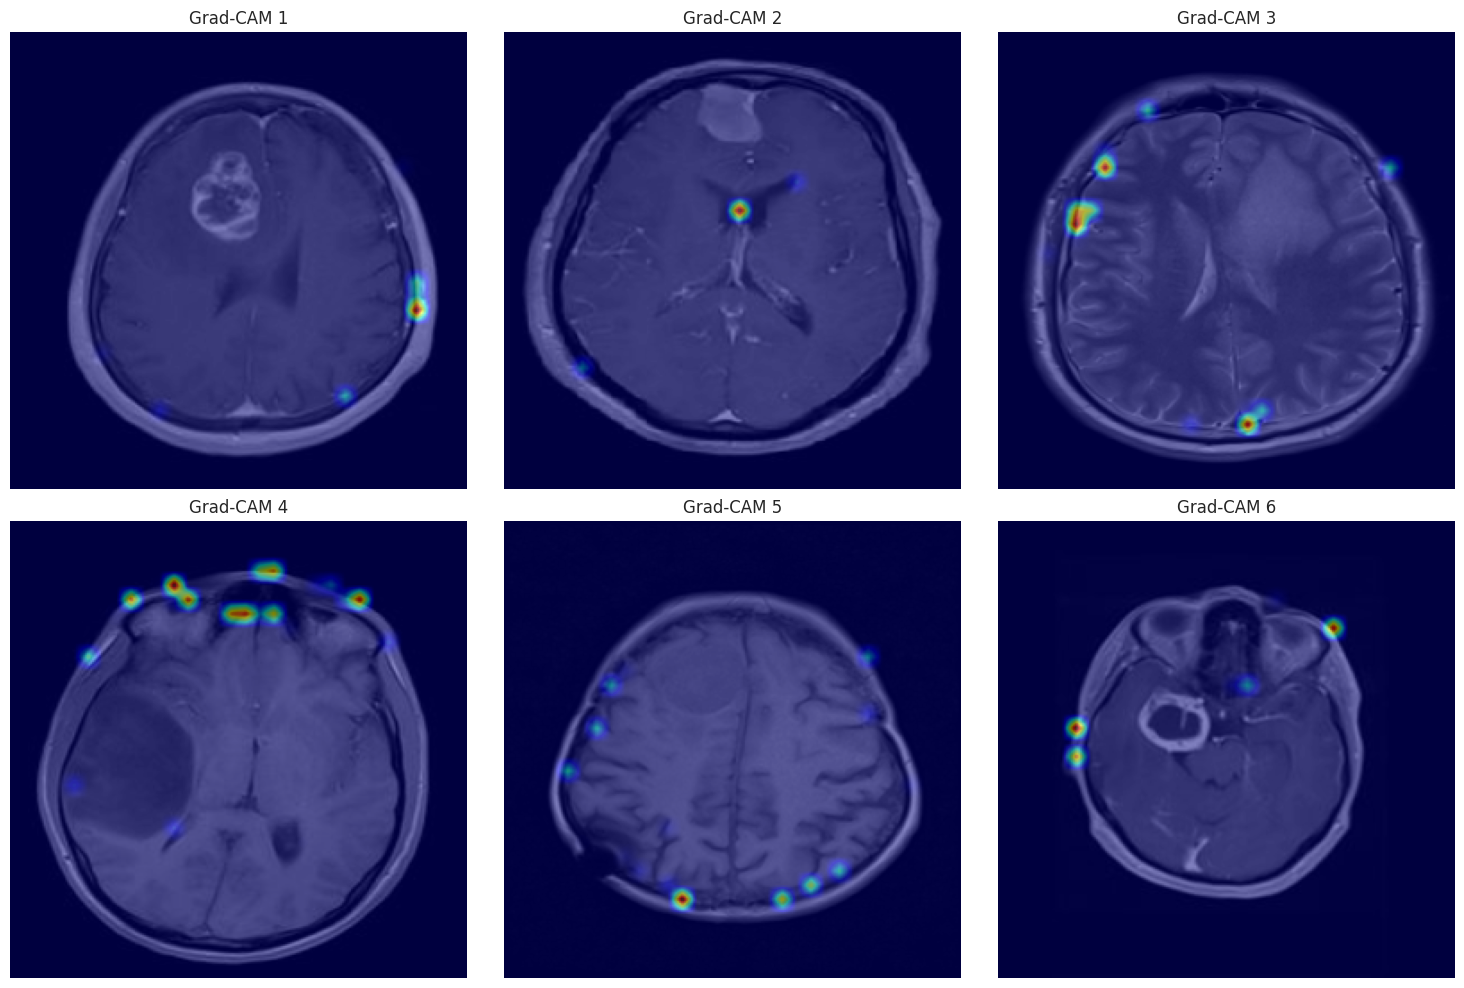

In [21]:
# ─────────────────────────────────────────────────────────────────────────────
# 8. Grad-CAM Visualization (Fixed with .detach() and Display 6 Outputs)
# ─────────────────────────────────────────────────────────────────────────────
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name

    def __call__(self, x):
        feats, grads = [], []

        def save_feat(m, i, o): feats.append(o)
        def save_grad(m, i, g): grads.append(g[0])

        # Register hooks
        layer = dict(self.model.named_modules())[self.layer_name]
        h1 = layer.register_forward_hook(save_feat)
        h2 = layer.register_backward_hook(save_grad)

        out = self.model(x)
        score = out.mean()
        self.model.zero_grad()
        score.backward()

        h1.remove()
        h2.remove()

        # Compute Grad-CAM heatmap (detached from graph)
        w = grads[0].detach().mean(dim=(2, 3), keepdim=True)
        cam = (feats[0].detach() * w).sum(1).squeeze().detach().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (256, 256))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


# Initialize Grad-CAM on discriminator layer
gradcam = GradCAM(model.D_B, 'model.7')

gradcam_out = os.path.join(OUT_DIR, "xai_gradcam")
os.makedirs(gradcam_out, exist_ok=True)

# Show 6 Grad-CAM maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (ax, p) in enumerate(zip(axes, mr_paths[::step][:n_show])):
    x = transform(dcm_to_pil(p)).unsqueeze(0).to(DEVICE)

    # Compute Grad-CAM
    cam = gradcam(x)

    # Convert input tensor to displayable image
    img_np = (x[0].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).squeeze()

    # Overlay Grad-CAM heatmap
    ax.imshow(img_np, cmap='gray')
    ax.imshow(cam, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Grad-CAM {i+1}")

    # Save each Grad-CAM heatmap
    plt.imsave(os.path.join(gradcam_out, f"gradcam_{i:03d}.png"), cam, cmap='jet')

plt.tight_layout()
plt.show()

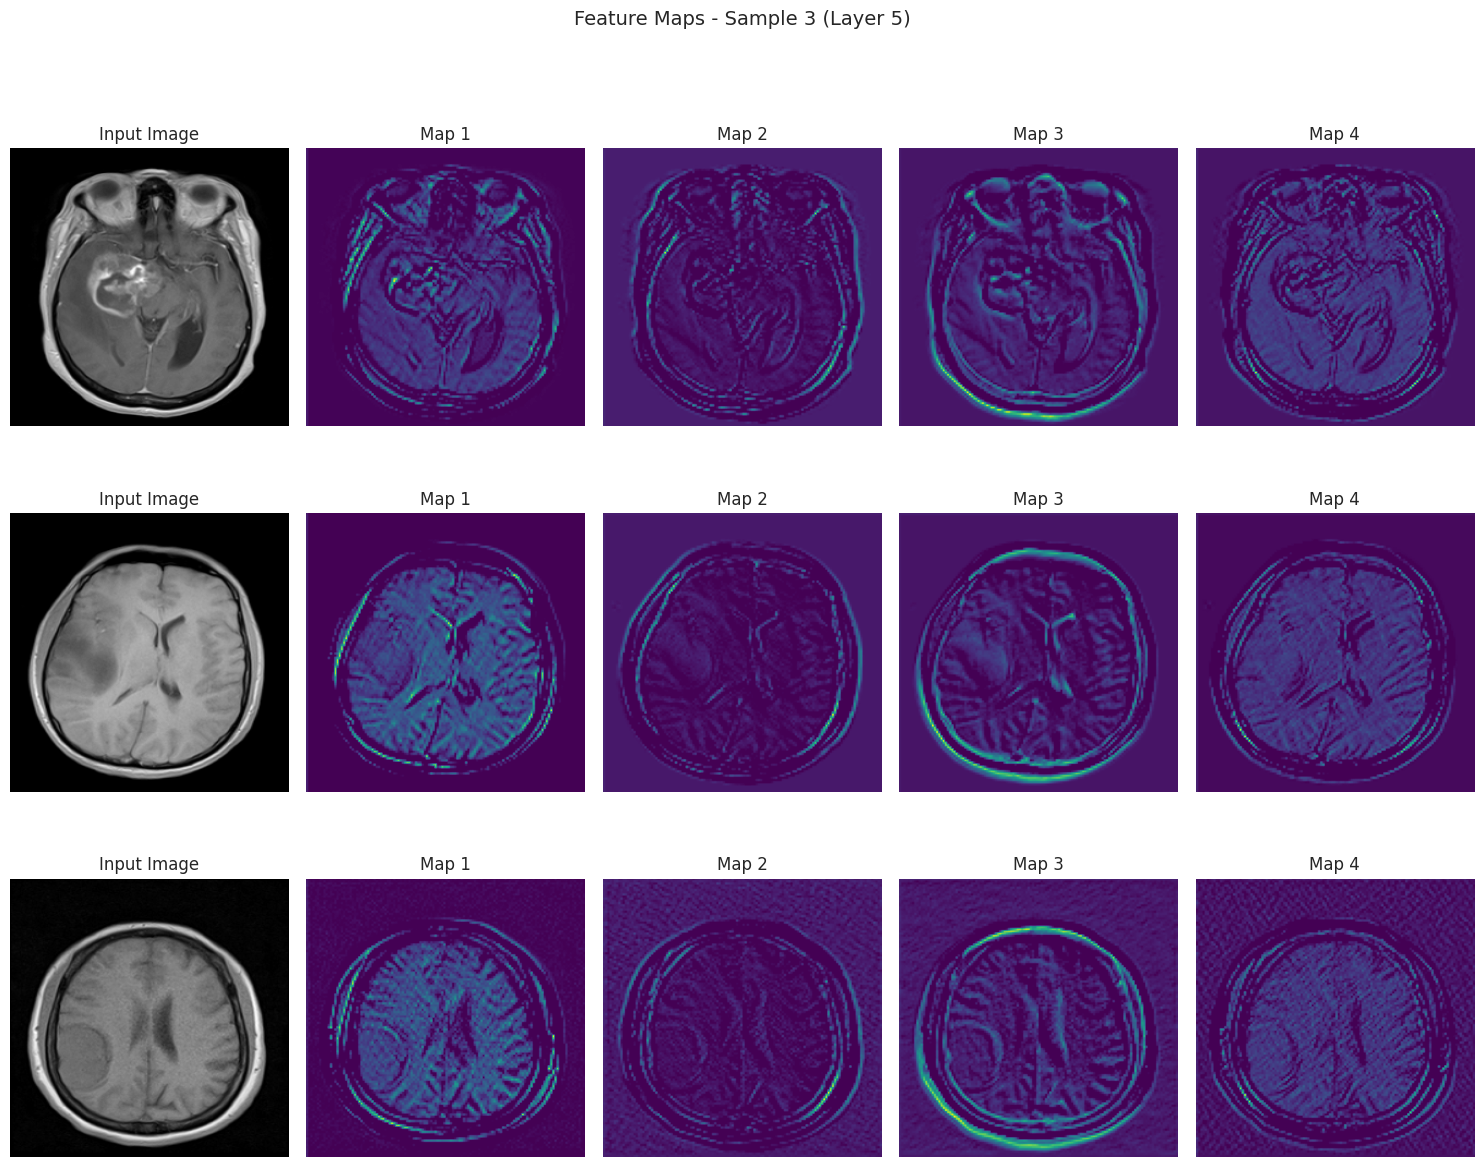

In [22]:
# ─────────────────────────────────────────────────────────────────────────────
# 9. Feature Maps Visualization (Multiple Samples)
# ─────────────────────────────────────────────────────────────────────────────
def visualize_feature_maps_multi(netG, dataloader, layer_idx=5, n_samples=3, save_dir='feature_maps_multi'):
    os.makedirs(save_dir, exist_ok=True)

    # Hook to capture activations
    act = {}
    def hook(m, i, o):
        act['out'] = o.detach()

    layer = list(netG.model.children())[layer_idx]
    handle = layer.register_forward_hook(hook)

    # Fetch n_samples from dataloader
    data_iter = iter(dataloader)
    samples = [next(data_iter)[0].to(DEVICE) for _ in range(n_samples)]

    fig, axes = plt.subplots(n_samples, 1 + 4, figsize=(3*(1+4), 4*n_samples))
    if n_samples == 1:
        axes = [axes]  # for consistent indexing

    for i, x in enumerate(samples):
        _ = netG(x)  # forward pass to get feature maps
        fmap = act['out'].cpu().squeeze(0)
        n_show = min(4, fmap.shape[0])

        # Input image
        img_np = (x[0].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5).squeeze()
        axes[i][0].imshow(img_np, cmap='gray')
        axes[i][0].set_title("Input Image")
        axes[i][0].axis('off')

        # Feature maps
        for j in range(n_show):
            axes[i][1 + j].imshow(fmap[j], cmap='viridis')
            axes[i][1 + j].set_title(f"Map {j+1}")
            axes[i][1 + j].axis('off')

        # Label row title
        fig.suptitle(f"Feature Maps - Sample {i+1} (Layer {layer_idx})", fontsize=14, y=1.02)

    handle.remove()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"layer_{layer_idx}_multi.png"), bbox_inches='tight')
    plt.show()

# Example usage
visualize_feature_maps_multi(model.G_A2B, dataloader, layer_idx=5, n_samples=3)